In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# 1. Деревья решений для классификации (продолжение)

На прошлом занятии мы разобрали идею Деревьев решений:

![DecisionTree](tree1.png)


Давайте теперь разберемся **как происходит разделения в каждом узле** то есть как проходит этап **обучения модели**. Есть как минимум две причины в этом разобраться : во-первых это позволит нам решать задачи классификации на 3 и более классов, во-вторых это даст нам возможность считать *важность* признаков в обученной модели.

Для начала посмотрим какие бывают деревья решений


----
Дерево решений вообще говоря **не обязано быть бинарным**, на практике однако используются именно бинарные деревья, поскольку для любоого не бинарного дерева решений **можно построить бинарное** (при этом увеличится глубина дерева).

### 1. Деревья решений использую простой одномерный предикат для разделения объектов

Имеется ввиду что в каждом узле разделение объектов (и создание двух новых узлов) происходит **по 1 (одному)** признаку: 

*Все объекты со значением некоторого признака меньше трешхолда отправляются в один узел, а больше - в другой:*

$$
[x_j < t]
$$

Вообще говоря это совсем не обязательно, например в каждом отдельном узле можно строить любую модель (например логистическую регрессию или KNN), рассматривая сразу несколько признаков.

### 2. Оценка качества 

Мы говорили про простой функционал качества разбиения (**выбора трешхолда**): количество ошибок (1-accuracy). 
На практике используются два критерия: Gini's impurity index и Information gain.

**Индекс Джини**
$$
I_{Gini} = 1 - \sum_i^K p_i^2 
$$

где $K$ - количество классов, a $p_i = \frac{|n_i|}{n}$ - доля представителей $i$ - ого класса в данном узле


**Энтропия**

$$
H(p) = - \sum_i^K p_i\log(p_i)
$$

**Информационный критерий**
$$
IG(p) = H(\text{parent}) - H(\text{child})
$$


#### Разделение производится по тому трешхолду и тому признаку по которому взвешенное среднее функционала качества в узлах потомках наименьшее.


### 3. Критерий остановки

Мы с вами говорили о таких параметрах Решающего дерева как минимальное число объектов в листе,
и минимальное число объектов в узле, для того чтобы он был разделен на два. Еще один критерий - 
глубина дерева. Возможны и другие.

* Ограничение числа объектов в листе
* Ограничение числа объектов в узле, для того чтобы он был разделен
* Ограничение глубины дерева
* Ограничение минимального прироста Энтропии или Информационного критерия при разделении
* Остановка в случае если все объекты в листе принадлежат к одному классу

На прошлой лекции мы обсуждали технику которая называется **Прунинг** (pruning) это альтернатива Критериям остановки, когда сначала строится переобученное дерево, а затем она каким то образом упрощается. На практике по ряду причин чаще используются критерии остановки, а не прунинг.

Подробнее см. https://github.com/esokolov/ml-course-hse/blob/master/2018-fall/lecture-notes/lecture07-trees.pdf

Оссобенности разбиения непрерывных признаков
* http://kevinmeurer.com/a-simple-guide-to-entropy-based-discretization/
* http://clear-lines.com/blog/post/Discretizing-a-continuous-variable-using-Entropy.aspx
---

## 1.1. Оценка качества разделения в узле

In [3]:
def gini_impurity(y_current):
    
    n = y_current.shape[0]
    val, count = np.unique(y_current, return_counts=True)
    gini = 1 - ((count/n)**2).sum()
        
    return gini

def entropy(y_current):
    
    gini = 1
    n = y_current.shape[0]
    val, count = np.unique(y_current, return_counts=True)
    p = count/n
    igain = p.dot(np.log(p))
    
    return igain

In [4]:
n = 100
Y_example = np.zeros((100,100))

for i in range(100):
    for j in range(i, 100):
        Y_example[i, j] = 1
        
gini = [gini_impurity(y) for y in Y_example]
ig = [-entropy(y) for y in Y_example]

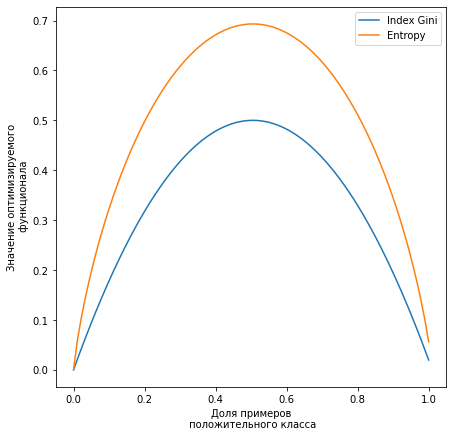

In [5]:
plt.figure(figsize=(7,7))

plt.plot(np.linspace(0,1,100), gini, label='Index Gini');
plt.plot(np.linspace(0,1,100), ig, label ='Entropy');
plt.legend()
plt.xlabel('Доля примеров\n положительного класса')
plt.ylabel('Значение оптимизируемого\n функционала');

## 1.2. Пример работы Решающего дерева

**Индекс Джини** и **Информационный критерий** это меры сбалансированности вектора (насколько значения объектов в наборе однородны). Максимальная неоднородность когда объектов разных классов поровну. Максимальная однородность когда в наборе объекты одного класса. 

Разбивая множество объектов на два подмножества, мы стремимся уменьшить неоднородность в каждом подмножестве.
Посмотрем на примере Ирисов Фишера

### Ирисы Фишера

In [6]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier


iris = load_iris()
model = DecisionTreeClassifier()
model = model.fit(iris.data, iris.target)

In [7]:
feature_names = ['sepal length', 'sepal width',  'petal length',  'petal width']
target_names = ['setosa', 'versicolor', 'virginica']

In [8]:
model.feature_importances_

array([0.        , 0.01333333, 0.56405596, 0.42261071])

In [9]:
np.array(model.decision_path(iris.data).todense())[0]

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
np.array(model.decision_path(iris.data).todense())[90]

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
iris.data[0]

array([5.1, 3.5, 1.4, 0.2])

In [12]:
model.predict(iris.data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [13]:
model.tree_.node_count

17

### Цифры. Интерпретируемость

In [14]:
from sklearn.datasets import load_digits

X, y = load_digits(n_class=2, return_X_y=True)

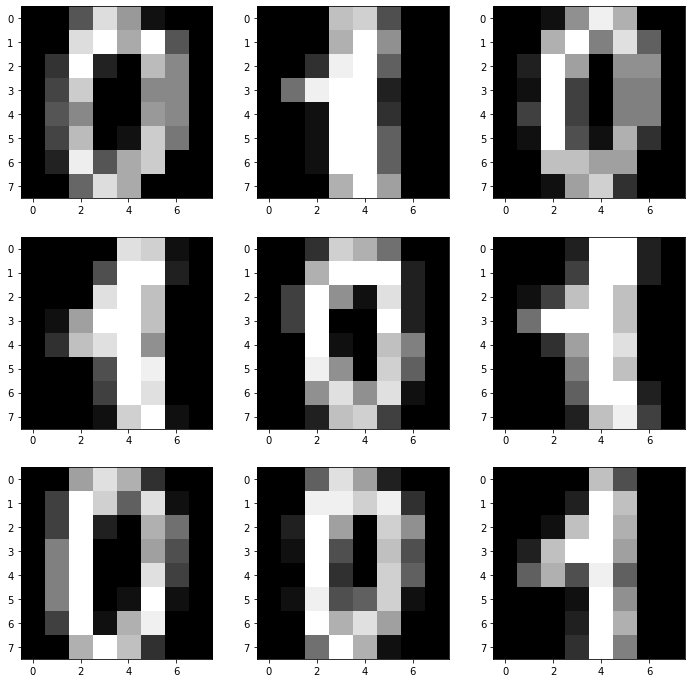

In [15]:
plt.figure(figsize=(12,12))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.imshow(X[i].reshape(8,8), cmap='gray')

In [16]:
model = DecisionTreeClassifier()
model.fit(X, y)
y_pred = model.predict(X)

print(accuracy_score(y, y_pred))
print(X.shape)

NameError: name 'accuracy_score' is not defined

In [ ]:
np.array(model.decision_path(X).todense())[0]

In [ ]:
model.feature_importances_

In [ ]:
plt.imshow(model.feature_importances_.reshape(8,8));

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(model, out_file='tree.dot', filled=True)

In [ ]:
# #sudo apt-get install graphviz

# !dot -Tpng 'tree.dot' -o 'tree.png'

# ![Iris_tree](tree.png)

In [ ]:
np.array(model.decision_path(X).todense())[0]

In [ ]:
plt.imshow(X[0].reshape(8,8))

## 2.3. Решающие деревья легко обобщаются на задачу многоклассовой классификации

### Пример с рукописными цифрами

In [ ]:
X, y = load_digits(n_class=10, return_X_y=True)

In [ ]:
plt.figure(figsize=(12,12))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.imshow(X[i].reshape(8,8), cmap='gray')
    ax.set_title(y[i])
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
model = DecisionTreeClassifier()
model.fit(X, y)
y_pred = model.predict(X)

print(accuracy_score(y, y_pred))

In [ ]:
plt.imshow(model.feature_importances_.reshape(8,8));

In [ ]:
model.feature_importances_

### Вопрос: откуда мы получаем feature importance?

## 2.4. Пример на котором дерево решений строит очень сложную разделяющую кривую

Пример взят отсюда https://habr.com/ru/company/ods/blog/322534/#slozhnyy-sluchay-dlya-derevev-resheniy .

Как мы помним Деревья используют одномерный предикат для разделени множества объектов.
Это значит что если данные плохо разделимы по **каждому** (индивидуальному) признаку по отдельности, результирующее решающее правило может оказаться очень сложным.

In [17]:
from sklearn.tree import DecisionTreeClassifier

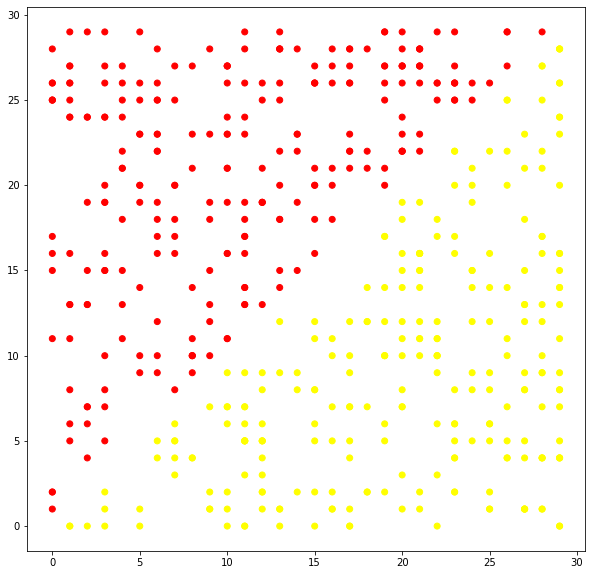

In [18]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1, x2 = np.random.randint(x1_min, x1_max), np.random.randint(x2_min, x2_max)

        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)

X, y = form_linearly_separable_data()
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn');

Давайте посмотрим как данные выглядит в проекции на 1 ось

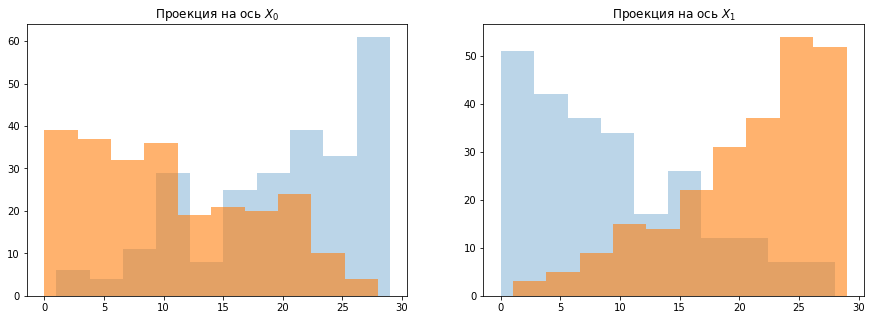

In [19]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('Проекция на ось $X_0$')
ax1.hist(X[y==1, 0], alpha=.3);
ax1.hist(X[y==-1, 0], alpha=.6);

ax2 = plt.subplot(1,2,2)
ax2.set_title('Проекция на ось $X_1$')
ax2.hist(X[y==1, 1], alpha=.3);
ax2.hist(X[y==-1, 1], alpha=.6);


In [20]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

<ipython-input-21-7799b03e2b13>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='autumn', alpha=0.3)


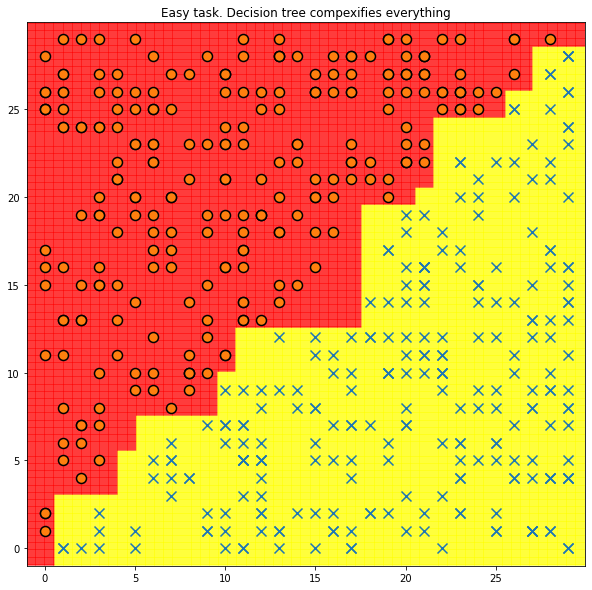

In [21]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)


xx, yy = get_grid(X, eps=.05)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(10,10))
plt.pcolormesh(xx, yy, predicted, cmap='autumn', alpha=0.3)
plt.scatter(X[y==1, 0], X[y==1, 1], marker='x', s=100, cmap='autumn',  linewidth=1.5)
plt.scatter(X[y==-1, 0], X[y==-1, 1], marker='o', s=100, cmap='autumn', edgecolors='k',linewidth=1.5)
plt.title('Easy task. Decision tree compexifies everything');

In [22]:
# export_graphviz(tree, out_file='complex_tree.dot', filled=True)
# !dot -Tpng 'complex_tree.dot' -o 'complex_tree.png'

## 2.5. Деревья решений для регрессии (кратко)

см. sklearn.DecisionTreeRegressor

# 3. Ансамблирование деревьев. Случайный лес.

### Идея 1

Что если у нас несколько классификаторов (каждый может быть не очень *умным*) ошибающихся на разных объектах
Тогда если в качестве предсказания мы будем использовать *моду* мы можем расчитывать на лучшую предсказательную силу.

Как получить модели которые ошибаются в разных местах?

Давайте брать *тупые* деревья но учить их на **разных подвыборках признаков** !

In [23]:
from sklearn.datasets import load_digits

X, y = load_digits(n_class=2, return_X_y=True)

In [24]:
for state in range(5):

    model = DecisionTreeClassifier(max_features=4, max_depth=2, random_state=state)
    model.fit(X, y)
    y_pred = model.predict(X)

    print('Точность классификатора: {:.3f}'.format(accuracy_score(y, y_pred)))
    
    
    print('Ненулевые признаки: {}'.format(np.nonzero(model.feature_importances_)))
    print('\n-------\n')

NameError: name 'accuracy_score' is not defined

In [25]:
model.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00537918, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.21229023, 0.        ,
       0.78233059, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

### Идея 2

Как получить модели которые ошибаются в разных местах?

Давайте брать *тупые* деревья, но учить их на **разных подвыборках объектов** !

### Результат: Случайный лес.

sklearn.ensemble RandomForrest